In [153]:
%matplotlib inline

import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import export_graphviz, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, precision_score, recall_score
from sklearn.datasets import load_breast_cancer, load_boston

from sklearn.ensemble import GradientBoostingClassifier

from sklearn import preprocessing
from sklearn import utils


# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

import itertools


In [154]:
d = pd.read_csv('data/cleaned_data_together.csv')
def df_cleaner(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    return df
df = df_cleaner(d)

In [155]:
df['Change'] = df['Henry Hub Price $/MMBtu'] - df['Henry Hub Price $/MMBtu'].shift(1)
df['Change']= df['Change'].fillna(0)

In [156]:
df['MOY'] =df['DateTime']
df['WOY'] =df['DateTime']
def moy(x):
    #test = df_shift_final['DateTime'][x]
    date = datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")
    return date.month
df['MOY'] = df['MOY'].apply(lambda x : moy(x))

In [157]:
def woy(x):
    #test = df_shift_final['DateTime'][x]
    date = datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")
    return int(date.strftime("%V"))
df['WOY'] = df['WOY'].apply(lambda x : woy(x))

In [158]:
df.head(2)

,DateTime,Henry Hub Price $/MMBtu,Temp,Production MMCF,Storage BCFE,Reserves BCFE,Consumption MMCF,DOY,Change,MOY,WOY
0,2010-01-01,5.82,26.0317,2197157.0,3117.0,255035.0,1666520.0,1,0.0,1,53
1,2010-01-02,5.82,24.2249,2197157.0,3117.0,255035.0,1666520.0,2,0.0,1,53


In [159]:
doy = df.pop('DOY')
woy = df.pop('WOY')

In [160]:
df = df.set_index('DateTime')

In [161]:
dfm =df.resample('M').mean()

In [162]:
dfm['one_back'] = dfm['Henry Hub Price $/MMBtu'].shift(1).fillna(method= 'backfill')

In [163]:
dfm['one_month_back_temp'] = dfm['Temp'].shift(1).fillna(method= 'backfill')
dfm['two_month_back_temp'] = dfm['Temp'].shift(2).fillna(method= 'backfill')
dfm['three_month_back_temp'] = dfm['Temp'].shift(3).fillna(method= 'backfill')
dfm['four_month_back_temp'] = dfm['Temp'].shift(4).fillna(method= 'backfill')

In [164]:
dfm['one_con_back'] = dfm['Consumption MMCF'].shift(1).fillna(method= 'backfill')

In [165]:
dfm['con_sto_diff'] = dfm['Storage BCFE'] - (dfm['Consumption MMCF']/1000)

In [166]:
dfm['one_diff_back'] = dfm['con_sto_diff'].shift(1).fillna(method= 'backfill')
dfm['two_diff_back'] = dfm['con_sto_diff'].shift(2).fillna(method= 'backfill')
dfm['three_diff_back'] = dfm['con_sto_diff'].shift(3).fillna(method= 'backfill')

In [167]:
dfm.columns

Index(['Henry Hub Price $/MMBtu', 'Temp', 'Production MMCF', 'Storage BCFE',
       'Reserves BCFE', 'Consumption MMCF', 'Change', 'MOY', 'one_back',
       'one_month_back_temp', 'two_month_back_temp', 'three_month_back_temp',
       'four_month_back_temp', 'one_con_back', 'con_sto_diff', 'one_diff_back',
       'two_diff_back', 'three_diff_back'],
      dtype='object')

In [179]:
fil = ['con_sto_diff']

In [169]:
y = dfm.pop('Henry Hub Price $/MMBtu').values

In [180]:
X = dfm[fil].values

In [181]:
size = int(len(X) * 0.75)
X_train, X_test, y_train, y_test = X[0:size], X[size:len(X)], y[0:size], y[size:len(y)]

In [184]:
X_train, X_test, y_train, y_test 
history_X = X_train
history_y = y_train
predictions2 = list()
rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
           max_features=1, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
rfr_fit = rfr.fit(X_train, y_train)
for t in range(len(y_test)):
    output = rfr_fit.predict(X_test[t].reshape((1,1)))
    yhat = output[0]
    predictions2.append(yhat)
#     obs = y_test[t]
#     history_X = np.append(history_X, X_test[t].reshape((1,6)), axis=0)
#     history_y = np.append(history_y,obs)
    #print('{} of {} predicted={}, expected={}'.format(t, len(y_test), yhat, obs))
pred = np.array(predictions2)
error = mean_squared_error(y_test, predictions2)
print('Test MSE: %.5f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

Test MSE: 0.60464


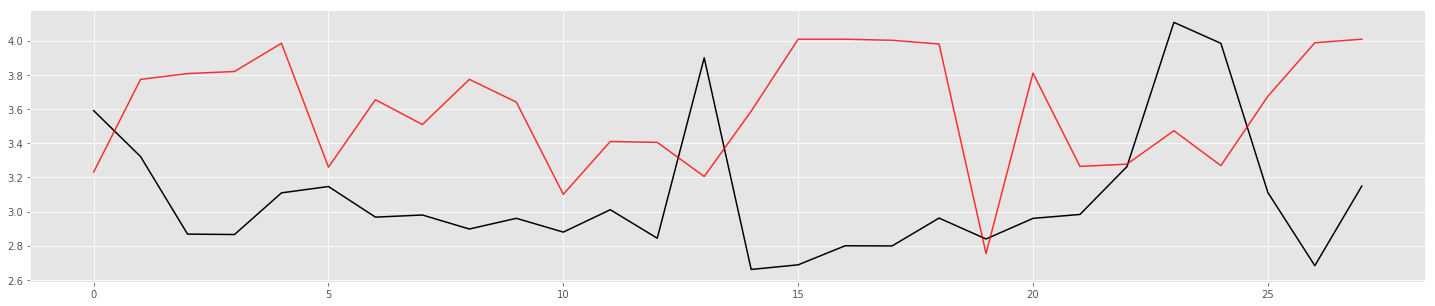

In [185]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(y_test, color='black')
axs.plot(predictions2, color='red', alpha = 0.8)
#axs.set_xlim([300, 600])
#axs.set_ylim([-0.2, .2])
plt.show()

In [189]:
y

array([5.81387097, 5.30214286, 4.27      , 3.99166667, 4.13580645,
       4.807     , 4.63193548, 4.3116129 , 3.89133333, 3.42645161,
       3.699     , 4.22225806, 4.46032258, 4.06357143, 3.95419355,
       4.24533333, 4.28645161, 4.529     , 4.39548387, 4.0483871 ,
       3.90866667, 3.56      , 3.20033333, 3.15322581, 2.6683871 ,
       2.52137931, 2.16516129, 1.944     , 2.44      , 2.43666667,
       2.94967742, 2.83225806, 2.843     , 3.32903226, 3.51666667,
       3.34354839, 3.34032258, 3.30642857, 3.81612903, 4.17066667,
       4.02903226, 3.81666667, 3.62064516, 3.42096774, 3.60733333,
       3.6783871 , 3.63866667, 4.25709677, 4.6283871 , 5.89392857,
       4.79322581, 4.657     , 4.56096774, 4.57966667, 4.07064516,
       3.90387097, 3.91866667, 3.77741935, 4.11      , 3.45645161,
       3.00322581, 2.85357143, 2.83193548, 2.612     , 2.84774194,
       2.77866667, 2.83516129, 2.76548387, 2.66      , 2.34193548,
       2.09933333, 1.9       , 2.28290323, 1.9762069 , 1.72419

In [188]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(dfm['con_sto_diff'], color='black')
axs.plot(y)
#axs.plot(predictions2, color='red', alpha = 0.8)
#axs.set_xlim([300, 600])
#axs.set_ylim([-0.2, .2])
plt.show()

ValueError: view limit minimum -36857.450000000004 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 1800x360 with 1 Axes>

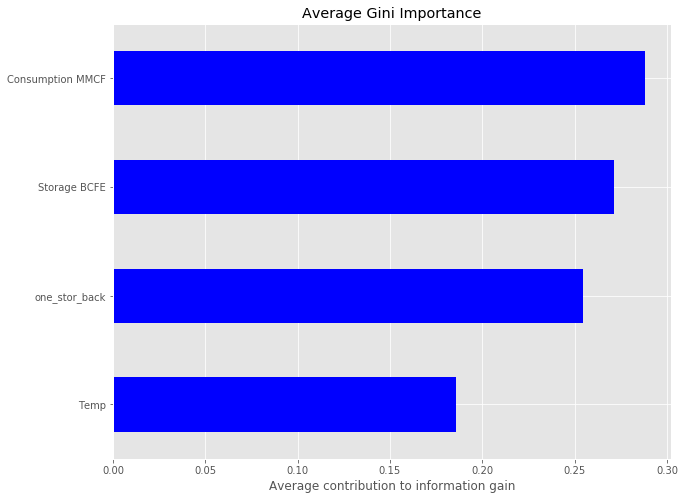

In [72]:
# Plot the feature importance
feat_scores = pd.Series(rfr.feature_importances_,
                           index=dfm[fil].columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');